## OpenAI commentary

*   Install required packages
*   Settings
*   Imports
*   Cache video
*   Extract key frames
*   Describe video
*   Combine video and audio
*   Install required packages



## Install required packages

In [1]:
!pip install -q pytube supervision openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


## Settings

In [9]:
VIDEO_URL = 'https://www.youtube.com/watch?v=rJmdmgRIb1g'

# fill in your openai api key
OPENAI_API_KEY = ''
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"

# depending on your video, you may need to sample more or less frequently
FRAME_EXTRACTION_FREQUENCY_SECONDS = 4

PROMPT = (
    f"The uploaded series of images is from a single video. "
    f"The frames were sampled every {FRAME_EXTRACTION_FREQUENCY_SECONDS} seconds. "
    f"Make sure it takes about {FRAME_EXTRACTION_FREQUENCY_SECONDS // 2} seconds to voice the description of each frame. "
    f"Use exclamation points and capital letters to express excitement if necessary. "
    f"Describe the video using Marv Albert style."
)

## Imports

In [3]:
import os
import re
import cv2
import base64
import requests

import supervision as sv
import numpy as np

from openai import OpenAI
from pytube import YouTube

## Cache video

In [11]:
def format_video_title(title: str) -> str:
    """
    Formats the video title by replacing spaces with hyphens, converting to lowercase,
    and removing special characters including commas, hash symbols, and hyphens.

    Args:
        title (str): The original video title.

    Returns:
        str: The formatted video title.
    """
    title = title.lower()
    title = re.sub(r'[^\w\s-]', '', title)
    title = re.sub(r'[-\s]+', '-', title)
    return title


def download_youtube_video(url: str, output_path: str = '.'):
    """
    Downloads a YouTube video to a specified output path.

    Args:
        url (str): URL of the YouTube video.
        output_path (str): Path where the video will be saved. Defaults to the current directory.
    """
    try:
        yt = YouTube(url)
        video_stream = yt.streams.filter(
            progressive=True,
            file_extension='mp4').order_by('resolution').desc().first()

        if video_stream:
            formatted_title = format_video_title(yt.title) + '.mp4'
            video_stream.download(output_path=output_path, filename=formatted_title)
            print(f"Video downloaded successfully: {formatted_title}")
            return formatted_title
        else:
            print("No suitable video stream found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [13]:
video_path = "/content/Emi Martinez's Last Minute Save vs France _ 2022 FIFA World Cup Final.mp4"

In [14]:
video_info = sv.VideoInfo.from_video_path(video_path=video_path)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=1549)

## Extract key frames

In [15]:
frame_extraction_frequency = FRAME_EXTRACTION_FREQUENCY_SECONDS * video_info.fps

In [16]:
frame_generator = sv.get_video_frames_generator(
        source_path=video_path,
        stride=frame_extraction_frequency)

frames = list(frame_generator)

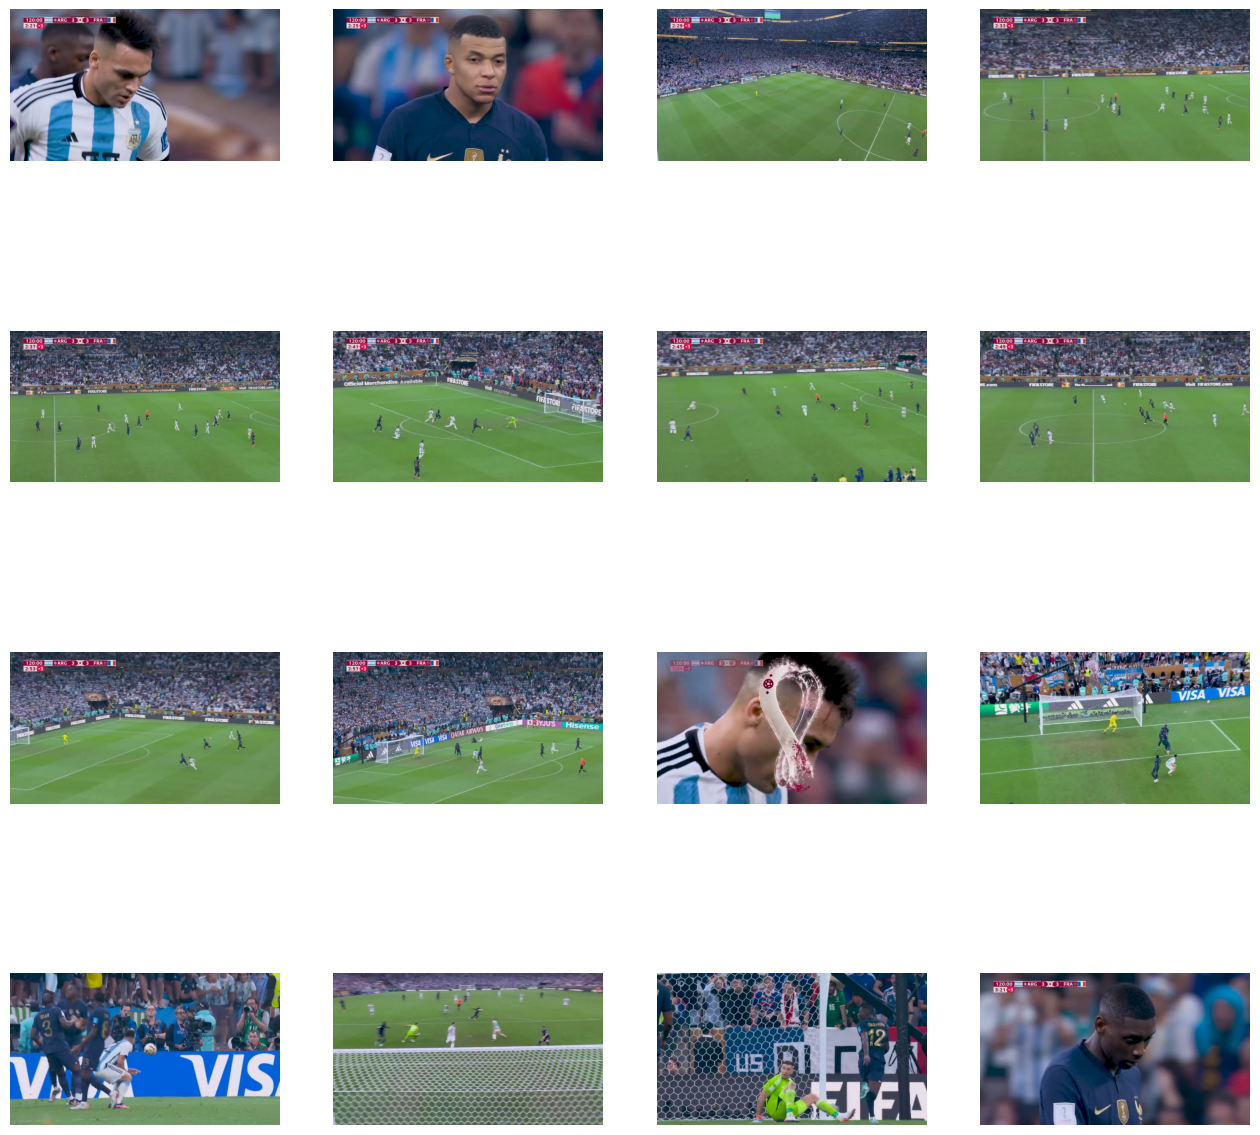

In [17]:
sv.plot_images_grid(frames, grid_size=(4, 4), size=(16, 16))

## Describing Video

In [21]:
def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

In [19]:
description = prompt_image(api_key=OPENAI_API_KEY, images=frames, prompt=PROMPT)

In [20]:
description

'Alright, here we go with a Marv Albert-style narration for each frame!\n\n1. **Frame 1:** "120th minute! It\'s all tied up at 3-3 between Argentina and France! What a match!"\n2. **Frame 2:** "The pressure is intense! France in the zone, eyes on the prize!"\n3. **Frame 3:** "Wide shot of the stadium! The crowd\'s electric, on their feet! We are witnessing history!"\n4. **Frame 4:** "Players spread out, energy surging across the pitch! This game isn\'t over yet!"\n5. **Frame 5:** "France pushing forward! A chance to score! This is nerve-wracking!"\n6. **Frame 6:** "Valiant defense from Argentina! They intercept, avoiding a disaster!"\n7. **Frame 7:** "Fast-paced action in the midfield! Both teams hungry for that decisive play!"\n8. **Frame 8:** "Argentina on the counterattack! Racing down the right side! This could be it!"\n9. **Frame 9:** "An opportunity! Argentina close to goal! What will happen next?!"\n10. **Frame 10:** "Intense focus on the Argentinian player! The weight of a nati

## Text to speach

In [22]:
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.audio.speech.create(
    model="tts-1",
    voice="alloy",
    input=description,
)

response.stream_to_file("fifa-output.mp3")